In [99]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import datetime
from datetime import date
import math
import random
from rdd import rdd

In [100]:
#Load data set here
data = pd.read_csv('../dataset_numeric.csv') 

In [101]:
# Filter by year (int) and paper category (Accept/Reject)

year = 2020
decision = 'all'
decision_to_numeric = {'all': [-1,3], 'accept':[1,3], 'reject':[-1,0], 'poster':[1,1], 'oral':[2,2], 'spotlight':[3,3]
                      , 'workshop':[0,0]}

if isinstance(year, int):
    data = data[data['year'] == year]
data = data[(decision_to_numeric[decision][0] <= data['decision']) & (data['decision'] <= decision_to_numeric[decision][1])]

# Average score
x = data.iloc[:, 3:4].values
for i in range (len(x)):
    arr = str(x[i][0]).split(";")
    for j in range (len(arr)):
        arr[j] = float(arr[j])
    if len(arr) != 0:
        val = sum(arr)/len(arr)
    x[i] = val
    
# Citation rate 
citations = data.iloc[:, 10:11].values
citations = [citation[0] for citation in citations]
dates = data.iloc[:, 2:3].values
now = datetime.datetime.now();
for i in range(len(dates)):
    arr = dates[i][0].split("/")
    d0 = date(int(arr[2]), int(arr[0]), int(arr[1]))
    d1 = date(now.year, now.month, now.day)
    delta = d1 - d0
    # Can either log transform or leave as-is
    citations[i] = float(citations[i]/delta.days)**(1/5)

In [102]:
# Convert x, citations to np arrays and make new dataframe
x = np.array([i[0] for i in x], dtype=float)
citations = np.array(citations, dtype=float)
data = pd.DataFrame({'x':x, 'citations':citations})

In [103]:
# Regression dicsontinuity design
# Set threshold and find optimal bandwidth
threshold = 6.4
bandwidth_opt = rdd.optimal_bandwidth(data['citations'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)
# Truncate data
data_rdd = rdd.truncated_data(data, 'x', bandwidth_opt, cut=threshold)


Optimal bandwidth: 1.6570316979623803


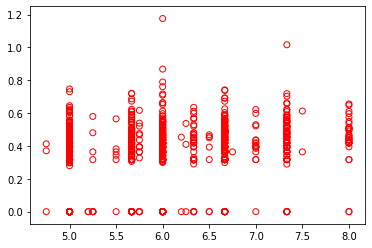

In [104]:
plt.scatter(data_rdd['x'], data_rdd['citations'], facecolors='none', edgecolors='r')

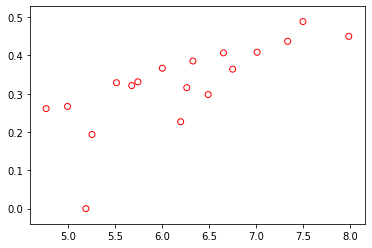

In [105]:
data_binned = rdd.bin_data(data_rdd, 'citations', 'x', 100)
plt.scatter(data_binned['x'], data_binned['citations'], facecolors='none', edgecolors='r')

In [106]:
model = rdd.rdd(data_rdd, 'x', 'citations', cut=threshold)
print(model.fit().summary())

Estimation Equation:	 citations ~ TREATED + x
                            WLS Regression Results                            
Dep. Variable:              citations   R-squared:                       0.094
Model:                            WLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     50.29
Date:                Mon, 03 Aug 2020   Prob (F-statistic):           1.65e-21
Time:                        23:57:39   Log-Likelihood:                 236.39
No. Observations:                 973   AIC:                            -466.8
Df Residuals:                     970   BIC:                            -452.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc

In [112]:
data_placebo = rdd.truncated_data(data, 'x', yname='citations', cut=1.01)

In [114]:
model = rdd.rdd(data_placebo, 'x', 'citations', cut=1.01)
print(model.fit().summary())

Estimation Equation:	 citations ~ TREATED + x
                            WLS Regression Results                            
Dep. Variable:              citations   R-squared:                       0.037
Model:                            WLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     6.315
Date:                Tue, 04 Aug 2020   Prob (F-statistic):            0.00203
Time:                        00:03:46   Log-Likelihood:                 125.88
No. Observations:                 336   AIC:                            -245.8
Df Residuals:                     333   BIC:                            -234.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interc